<a href="https://colab.research.google.com/github/ZohebAbai/Deep-Learning-Projects/blob/master/04_TF_Image_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Generation using VAE

**Steps**
- Import Libraries
- Download Dataset
- Define Hyperparams/Configs
- Visualize Dataset
- Data Generator with Augmentation
- Build the VAE Model using Probabilistic Layers
- Reduce LR on Plateau Scheduler and Checkpoint
- Model Training
- New Generated Faces
- Reconstructing Faces
- Feature Manipulation
- Face Morphing
- Visualize clusters on UMAP-reduced 1D latent vector


## Import Libraries

In [4]:
!pip install umap-learn

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 1.1 MB 23.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=99c48ebfee797225e1f943143c05130ab19997fbd07ac1d0c7554b91986f2366
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=464e57b1309c6e7e848160dab7e22bdfb02a853795f9e59a620f67c600fffaa3
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successfully built umap-learn pynndescent


In [5]:
!pip install hdbscan

     |████████████████████████████████| 5.2 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp37-cp37m-linux_x86_64.whl size=2330796 sha256=4940fe0c3bba88a73ca6aaf16c51f6f70da228899605ba5ff3f09e7c26f42dfe
  Stored in directory: /root/.cache/pip/wheels/6e/7a/5e/259ccc841c085fc41b99ef4a71e896b62f5161f2bc8a14c97a
Successfully built hdbscan


In [1]:
import os
import numpy as np
import pandas as pd
import shutil
import random
from collections import namedtuple
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')
import hdbscan
import umap

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_probability as tfp

from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization, ReLU, LeakyReLU, Dropout, UpSampling2D, Lambda
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau

tfpd =  tfp.distributions 
tfpl = tfp.layers

np.random.seed(101)
tf.random.set_seed(101)
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


## Download the Dataset

In [12]:
# copy the csv file for labels and the dataset folder
data_dir = '/content/data/'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    try:
        shutil.copy("/content/drive/MyDrive/Dataset/CelebA/img_align_celeba.zip", "/content/data/")
        shutil.copy("/content/drive/MyDrive/Dataset/CelebA/list_attr_celeba.csv", "/content/data/")
        print("File downloaded successfully.")
 
    # If source and destination are same
    except:
        print("Error occurred while copying file.")

    # Unzip the tar file
    shutil.unpack_archive("/content/data/img_align_celeba.zip", "/content/data/")
    # Remove the tar file
    os.remove("/content/data/img_align_celeba.zip")

File downloaded successfully.


## Define Hyperparams/Configs

In [2]:
def get_configs(**kwargs):
    return namedtuple('GenericDict', kwargs.keys())(**kwargs)

configs = get_configs(
    data_dir = "/content/data/",
    img_dir = "/content/data/img_align_celeba",
    img_size = (128,128),
    latent_dim = 128,
    max_lr= 1e-03, 
    batch_size= 512, 
    n_epochs= 60, 
    )

## Visualize Dataset

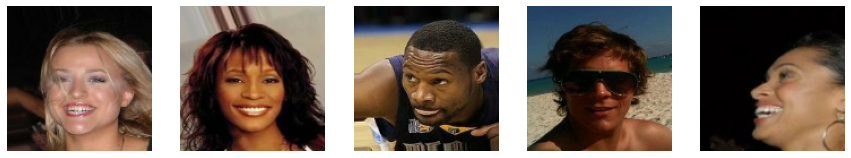

In [3]:
# View a random image
def view_random_image(img_dir):
    fig = plt.figure(figsize=(15,5))
    for i in range(5):
        # Get a random image path
        random_image = random.sample(os.listdir(img_dir), 1)
        filename = img_dir+'/'+random_image[0]
        img = tf.io.read_file(filename)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, configs.img_size)
        img = img/255.
        ax=fig.add_subplot(1,5,i+1)
        ax.axis("off")
        plt.imshow(img)
    plt.show()

view_random_image(configs.img_dir)

We consider reshaping the images to dim 128 to learn features better.

## Data Generator with Augmentation

In [3]:
data_flow = ImageDataGenerator(rescale=1./255)

train_data = data_flow.flow_from_directory(configs.data_dir,
                                                target_size=configs.img_size,
                                                batch_size=configs.batch_size,
                                                class_mode='input',
                                                shuffle = True)

Found 202599 images belonging to 1 classes.


## Build the VAE Model (using Probabilistic Layers)
The reason we finally choose 128-dim latent vector is because of variance in the distribution, which affects the cluster centres determination for high-dim latent vectors. Also we don't choose low-dim because of low quality of generated images. 128-dim is a good balance.

### Sampling
Now, since we are sampling a random point from an area around mu, the decoder must ensure that all points in the same neighborhood produce very similar images when decoded, so that the reconstruction loss remains small.

In [4]:
# distribution instance corresponding to b as in KL[a, b]
prior = tfpd.Independent(tfpd.Normal(loc=tf.zeros(configs.latent_dim), scale=1),
                        reinterpreted_batch_ndims=1)

### Encoder 
A model that takes an input image and encodes it into the 2D latent space, by sampling a point from the normal distribution defined by mu and log of variance. We choose to map to the logarithm of the variance, as this can take any real number in the range (–inf, inf), matching the natural output range from a neural network unit, whereas variance values are always positive.
KL divergence term penalizes the network for encoding observations to mu and log_var variables that differ significantly from the parameters of a standard normal distribution, namely mu = 0 and log variance = 0.

In [5]:
encoder = Sequential([
    InputLayer(input_shape=(configs.img_size[0], configs.img_size[1], 3)),
    Lambda(lambda x: tf.cast(x, tf.float32) - 0.5),
    Conv2D(32, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.25),
    Conv2D(64, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.25),
    Conv2D(64, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.25),
    Conv2D(128, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.25),
    Conv2D(128, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(tfpl.MultivariateNormalTriL.params_size(configs.latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(configs.latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
])

encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                        

###  Decoder
A model that takes a point in the latent space and decodes it into the original image domain. 

In [6]:
decoder = Sequential([
    InputLayer(input_shape=[configs.latent_dim]),
    Reshape([1, 1, configs.latent_dim]),
    Conv2DTranspose(128, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(128, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2DTranspose(64, 5, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2DTranspose(64, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2DTranspose(64, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2DTranspose(32, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2DTranspose(32, 3, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(rate = 0.2),
    Conv2D(filters=3, kernel_size=3, strides=1, padding='same', activation=None),
    Flatten(),
    tfpl.IndependentBernoulli((configs.img_size[0], configs.img_size[1], 3), tfpd.Bernoulli.logits),
])

decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 2, 2, 128)        147584    
 nspose)                                                         
                                                                 
 batch_normalization_5 (Batc  (None, 2, 2, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 2, 2, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 4, 4, 128)        147584    
 ranspose)                                                       
                                                      

### Compile

In [7]:
# Negative Log Likelihood as loss function
with tf.device(device_name):
    vae = Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]))
    negloglik = lambda x, rv_x: -rv_x.log_prob(x)
    vae.compile(optimizer=Adam(learning_rate=configs.max_lr), loss=negloglik)

## Reduce LR on Plateau Scheduler and Checkpoint

In [8]:
# LR Scheduler
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.1, mode='min',
                              patience=3, min_delta=1, min_lr=1e-07, verbose=0)
# model checkpoint
checkpoint = ModelCheckpoint(filepath='/content/weights.h5', save_weights_only=True, 
                             monitor='loss', mode='min', save_best_only=True, verbose=0)

## Model Training

In [9]:
history = vae.fit(train_data, 
                  epochs = configs.n_epochs, 
                  callbacks = [reduce_lr, checkpoint])

Epoch 1/60
396/396 [==============================] - 275s 678ms/step - loss: 28804.8652 - lr: 0.0010
Epoch 2/60
396/396 [==============================] - 266s 670ms/step - loss: 26255.1543 - lr: 0.0010
Epoch 3/60
396/396 [==============================] - 263s 663ms/step - loss: 25739.3574 - lr: 0.0010
Epoch 4/60
396/396 [==============================] - 262s 661ms/step - loss: 25515.6895 - lr: 0.0010
Epoch 5/60
396/396 [==============================] - 265s 668ms/step - loss: 25389.4824 - lr: 0.0010
Epoch 6/60
396/396 [==============================] - 261s 660ms/step - loss: 25318.4648 - lr: 0.0010
Epoch 7/60
396/396 [==============================] - 260s 657ms/step - loss: 25274.4883 - lr: 0.0010
Epoch 8/60
396/396 [==============================] - 262s 661ms/step - loss: 25239.0605 - lr: 0.0010
Epoch 9/60
396/396 [==============================] - 259s 654ms/step - loss: 25210.7676 - lr: 0.0010
Epoch 10/60
396/396 [==============================] - 258s 652ms/step - loss: 251

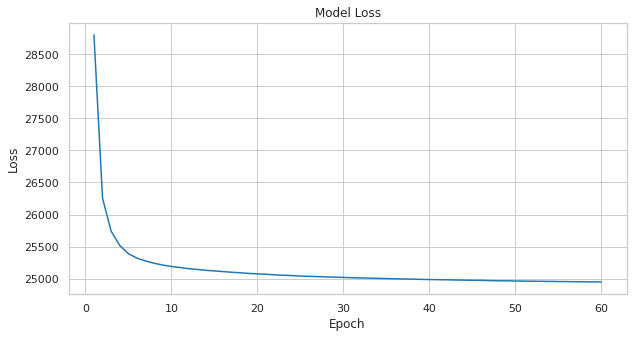

In [10]:
# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(range(1,len(history.history['loss'])+1), history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## New generated faces
Generating faces from random latent space normal distribution

In [11]:
def display_imgs(x):
    if not isinstance(x, (np.ndarray, np.generic)):
        x = np.array(x)
    n = x.shape[0]
    fig, axs = plt.subplots(1, n, figsize=(n*2, 5))
    for i in range(n):
        axs.flat[i].imshow(x[i].squeeze(), interpolation='gaussian')
        axs.flat[i].axis('off')
    plt.show()
    plt.close()

In [12]:
vae.load_weights("weights.h5")

Generated:


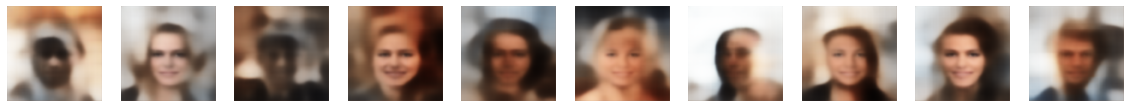

In [13]:
n_to_show = 10
z = prior.sample(n_to_show)
reconst = decoder(z)

print("Generated:")
display_imgs(reconst.mean())

The VAE is able to take the set of points that we sampled and convert each into a convincing image of a person’s face.

## Reconstructing Images

Reconstructing faces from input images

Originals:


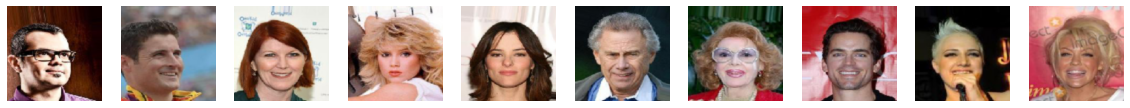

Reconstructed:


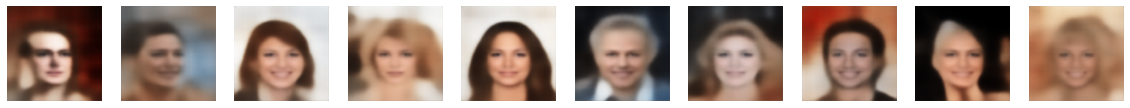

In [14]:
example_images = next(iter(train_data))[0][:10]
reconst_images = vae(example_images)

print('Originals:')
display_imgs(example_images)

print('Reconstructed:')
display_imgs(reconst_images.mean())

We can see that the VAE has successfully captured the key features of each face—the angle of the head, the hairstyle, the expression, etc. Some of the fine detail is missing, but it is important to remember that the aim of building variational autoencoders isn’t to achieve perfect reconstruction loss. Our end goal is to sample from the latent space in order to generate new faces.

**Its very evident that VAEs tend to produce softer images that has blurred boundaries.**

## Feature Manipulation

One benefit of mapping images into a lower-dimensional space is that we can perform arithmetic on vectors in this latent space that has a visual analogue when decoded back into the original image domain.

For example, suppose we want to take an image of somebody who looks sad and give them a smile. To do this we first need to find a vector in the latent space that points in the direction of increasing smile. Adding this vector to the encoding of the original image in the latent space will give us a new point which, when decoded, should give us a more smiley version of the original image.


In [15]:
attr = pd.read_csv('/content/data/list_attr_celeba.csv')
attr.head()

File_name  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0  000001.jpg                -1  ...               -1      1
1  000002.jpg                -1  ...               -1      1
2  000003.jpg                -1  ...               -1      1
3  000004.jpg                -1  ...               -1      1
4  000005.jpg                -1  ...               -1      1

[5 rows x 41 columns]

### Functions to getting vectors for corresponding label

In [16]:
from tensorflow.python.ops.gen_math_ops import zeta
def get_vector_from_label(label, batch_size):
    
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr, configs.img_dir, 
                                                   x_col='File_name', 
                                                   y_col = label,
                                                   target_size=configs.img_size , 
                                                   class_mode='raw', 
                                                   batch_size=batch_size, 
                                                   shuffle=True)

    # Initiating vectors 
    origin = np.zeros(shape = configs.latent_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = configs.latent_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = configs.latent_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = configs.latent_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = configs.latent_dim, dtype = 'float32')

    current_vector = np.zeros(shape = configs.latent_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : del distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = encoder(np.array(im)).mean().numpy()

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        # For positive attributes
        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        # For negative attributes
        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector

In [20]:
# Respective attribute vectors
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
bald_vec = get_vector_from_label('Bald', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
mustache_vec = get_vector_from_label('Mustache', BATCH_SIZE)
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 validated image filenames.
label: Attractive
images : POS move : NEG move :distance : del distance
261    : 1.33    : 1.014    : 1.302    : 1.302
512    : 0.379    : 0.455    : 1.164    : -0.137
787    : 0.262    : 0.227    : 1.076    : -0.088
1048    : 0.151    : 0.192    : 1.06    : -0.015
1313    : 0.128    : 0.132    : 1.035    : -0.026
1571    : 0.096    : 0.111    : 1.014    : -0.021
1830    : 0.083    : 0.09    : 1.03    : 0.016
2073    : 0.068    : 0.083    : 1.026    : -0.003
2335    : 0.077    : 0.067    : 0.997    : -0.03
2581    : 0.064    : 0.074    : 0.982    : -0.015
2828    : 0.051    : 0.065    : 0.97    : -0.012
3063    : 0.046    : 0.065    : 0.96    : -0.01
3319    : 0.048    : 0.045    : 0.951    : -0.009
3582    : 0.041    : 0.048    : 0.954    : 0.002
3853    : 0.04    : 0.041    : 0.95    : -0.004
4106    : 0.033    : 0.041    : 0.944    : -0.005
Found the Attractive vector
Found 202599 validated image filenames.
label: Bald
images : POS move : NEG 

### Functions to apply arithmetic on latent space to add features on generated images

In [18]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr, configs.img_dir, 
                                                   x_col='File_name', 
                                                   target_size=configs.img_size, 
                                                   class_mode='input', 
                                                   batch_size=n_to_show, 
                                                   shuffle=True)
    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = encoder(example_images).mean().numpy()

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = decoder(tf.expand_dims(changed_z_point, axis=0)).mean()

            img = tf.squeeze(changed_image, axis=0)
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img.numpy())

            counter += 1

    plt.show()

Attractive Vector
Found 202599 validated image filenames.


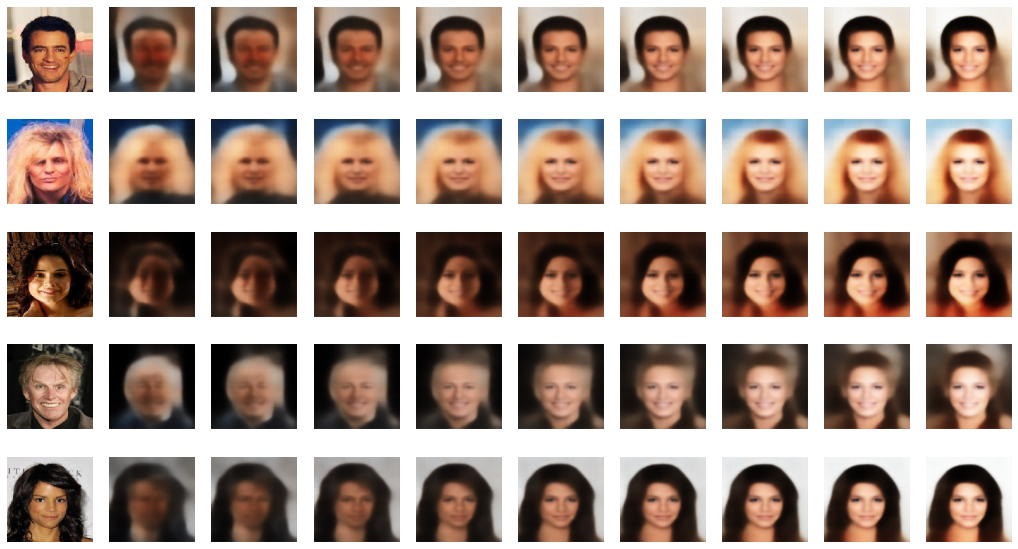

In [21]:
print('Attractive Vector')
add_vector_to_images(attractive_vec)

Bald Vector
Found 202599 validated image filenames.


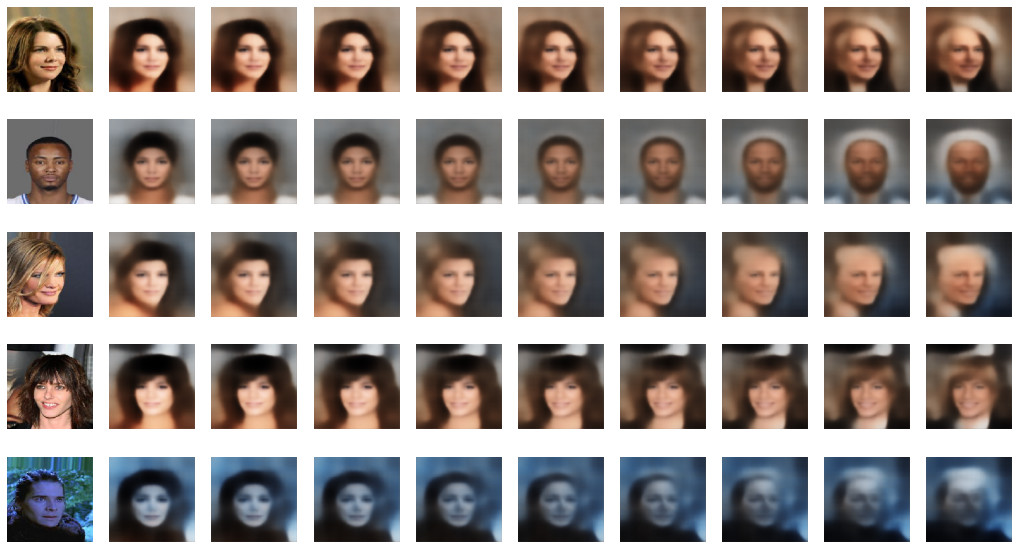

In [22]:
print('Bald Vector')
add_vector_to_images(bald_vec)

Smiling Vector
Found 202599 validated image filenames.


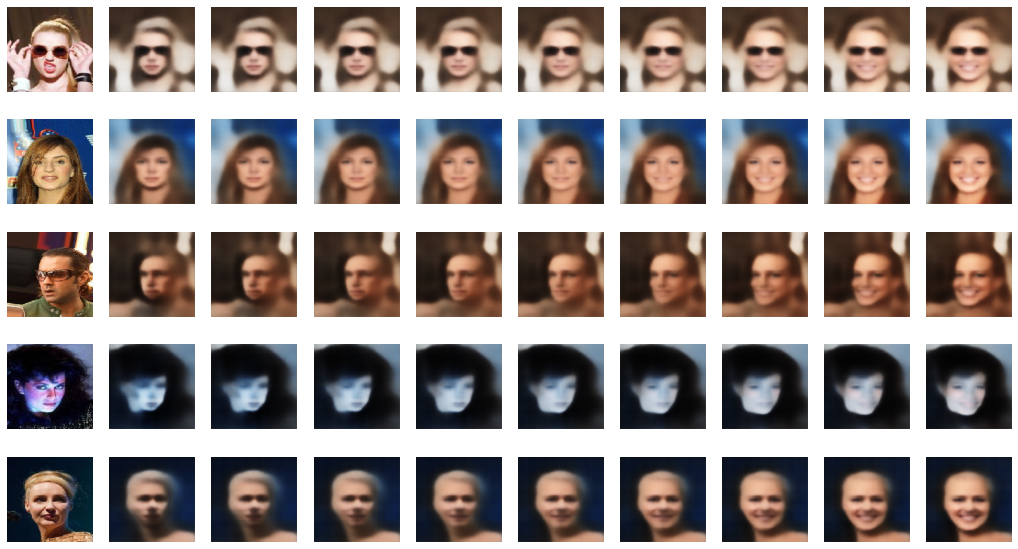

In [23]:
print('Smiling Vector')
add_vector_to_images(smiling_vec)

Moustache Vector
Found 202599 validated image filenames.


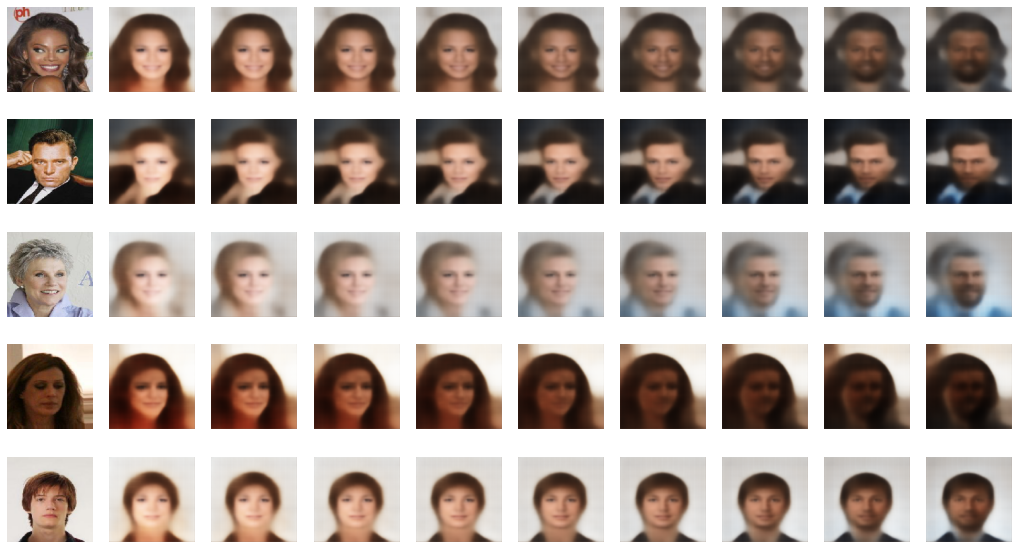

In [24]:
print('Moustache Vector')
add_vector_to_images(mustache_vec)

Eyeglasses Vector
Found 202599 validated image filenames.


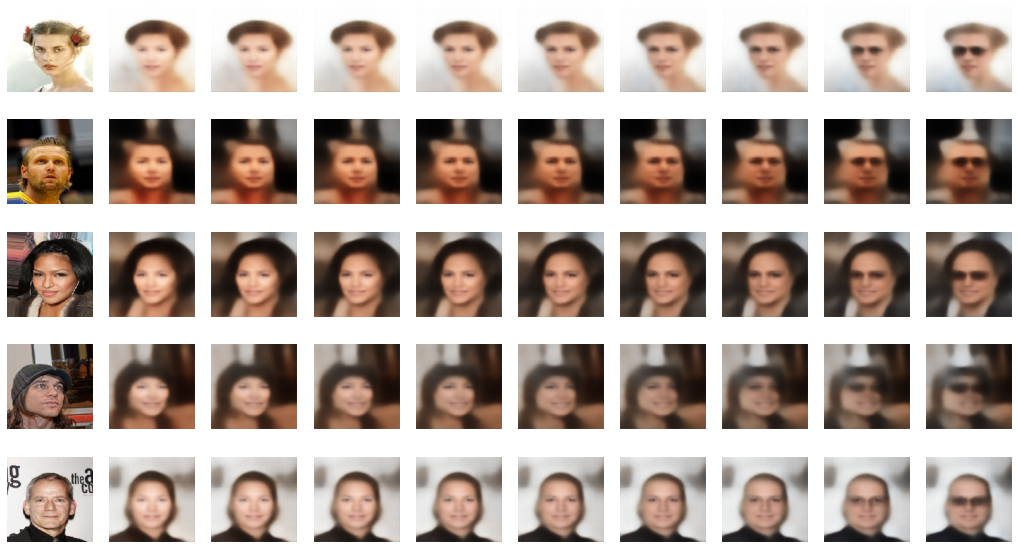

In [25]:
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

## Face Morphing

We can use a similar idea to morph between two faces. Imagine two points in the latent space, A and B, that represent two images. If you started at point A and walked toward point B in a straight line, decoding each point on the line as you went, you would see a gradual transition from the starting face to the end face.


In [26]:
def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    attr_specific = attr[attr['File_name'].isin([start_image_file, end_image_file])]
    attr_specific = attr_specific.reset_index()
    data_gen = ImageDataGenerator(rescale=1./255)
    data_flow_label = data_gen.flow_from_dataframe(attr_specific, configs.img_dir, 
                                                   x_col='File_name', 
                                                   target_size=configs.img_size, 
                                                   class_mode='input', 
                                                   batch_size=2, 
                                                   shuffle=True)
    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = encoder(example_images).mean().numpy()


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = decoder(tf.expand_dims(changed_z_point, axis=0)).mean()

        img = tf.squeeze(changed_image, axis=0)
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img.numpy())

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

Found 2 validated image filenames.


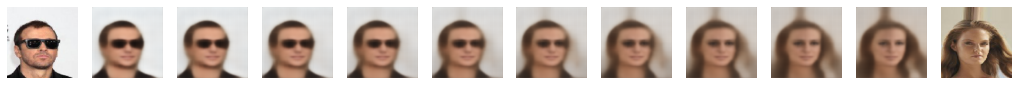

In [27]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 validated image filenames.


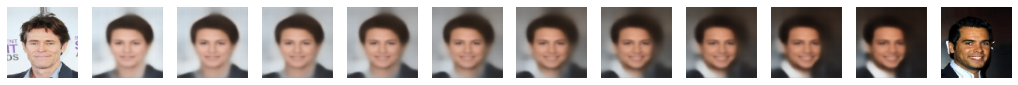

In [28]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)

**The latent space of the VAE is truly a continuous space that can be traversed and explored to generate a multitude of different human faces.**

## Visualize clusters on UMAP-reduced 1D latent vector

We tried both pca and tsne for dim reduction but umap gave us the best results.

total images: 512 
total number of labels: 41


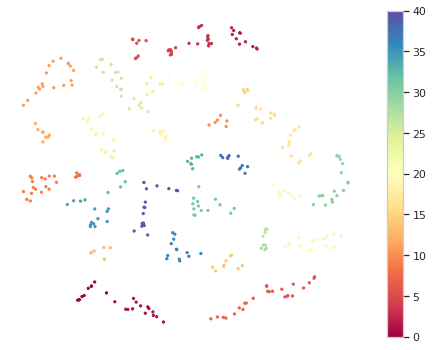

In [31]:
x, y = train_data[0]
z_points = encoder(x).sample().numpy()

clusterable_embedding = umap.UMAP(
    n_neighbors=4,
    min_dist=0.0,
    n_components=2,
    metric='cosine',
    random_state=101).fit_transform(z_points)

labels = hdbscan.HDBSCAN(min_cluster_size=4).fit_predict(clusterable_embedding)
print(f"total images: {x.shape[0]} \ntotal number of labels: {len(np.unique(labels)[1:])}")
clustered = (labels >= 0)
plt.figure(figsize=(8,6))
plt.scatter(clusterable_embedding[clustered,0], clusterable_embedding[clustered,1], c=labels[clustered], s=5, cmap='Spectral');
plt.grid(False)
plt.axis('off')
plt.colorbar()
plt.show()

In [32]:
print(f"Cluster silhouette score: {silhouette_score(clusterable_embedding,labels)}")

Cluster silhouette score: 0.23721224069595337


### Display Images for a random cluster label

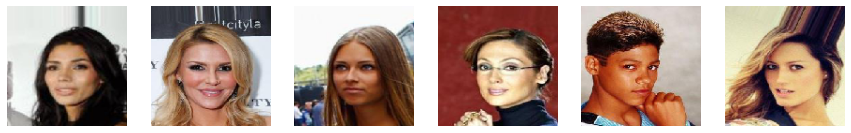

In [37]:
rch = random.choice(np.unique(labels)[1:])
imgs = x[np.where(labels == rch)]
fig = plt.figure(figsize=(15,5))
for i in range(len(imgs)):
    ax=fig.add_subplot(1,len(imgs),i+1)
    ax.axis("off")
    plt.imshow(imgs[i])
plt.show()